In [7]:
# Importation librairies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [8]:
# ====== IMPORTATION DU JEU DE DONNEES ======
client = pd.read_csv(r"../data/NewDataClient.csv")
print("Jeu de données importé ✅✅")

Jeu de données importé ✅✅


In [11]:
# ====== PRETRAITEMENT ======
# Séparation des colonnes dates
# colonne_de_date_a_separer = ["date_inscription","date_dernier_achat"]
# client =client.drop(columns=colonne_de_date_a_separer)

# Copie du jeu de données
data_client = client.copy()

# Séparation des types de données
num_col =data_client.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_col = data_client.select_dtypes(include=['object']).columns.tolist()

# Définition de pipeline
num_transformer = Pipeline([
    ('impute', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ("impute", SimpleImputer(strategy='constant',fill_value="Missing")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Colum Transformer
preprocessor = ColumnTransformer(
    transformers =[
        ('num',num_transformer,num_col),
        ('cat',cat_transformer,cat_col)
    ]
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca',PCA(n_components=10))
])

# Application
data_transformed = pipeline.fit_transform(data_client)
print("ACP éffectué ✅✅")

ACP éffectué ✅✅


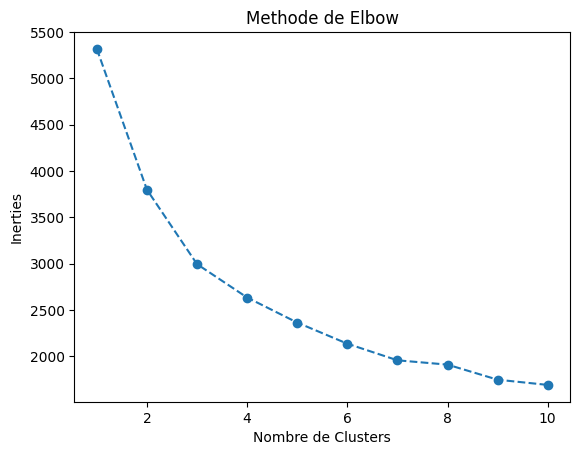

In [12]:
# ====== CHOIX DU k-OPTIMAL POUR LE CLUSTERING ======
# Méthode de Elbow
inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters= k, random_state=42)
    kmeans.fit_predict(data_transformed)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker="o",linestyle='--')
plt.title("Methode de Elbow")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Inerties")
plt.show()

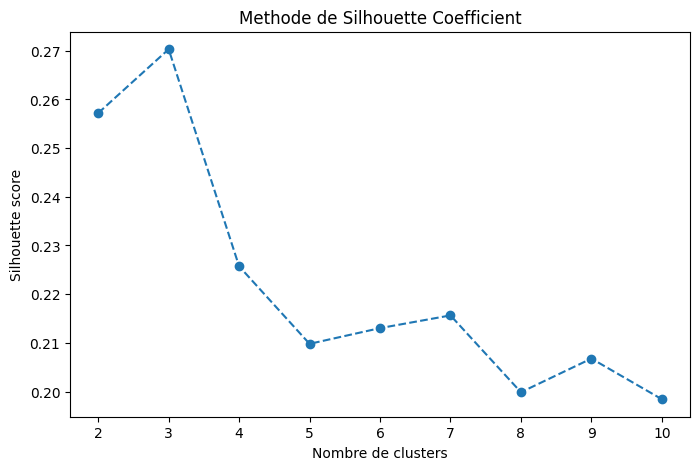

In [13]:
# Silhouette Coefficient
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_transformed)
    score = silhouette_score(data_transformed, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(range(2,11), silhouette_scores, marker="o",linestyle="--")
plt.title("Methode de Silhouette Coefficient")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.show()

In [16]:
# ====== APPLICATION DU KMEANS ======
optimal_k =3
kmean = KMeans(n_clusters=3, random_state=42)
clusters = kmean.fit_predict(data_transformed)
data_client["Clusters"] = clusters
print("KMeans éffectué ✅✅")

KMeans éffectué ✅✅


ACP appliquée pour visualiser les centroids


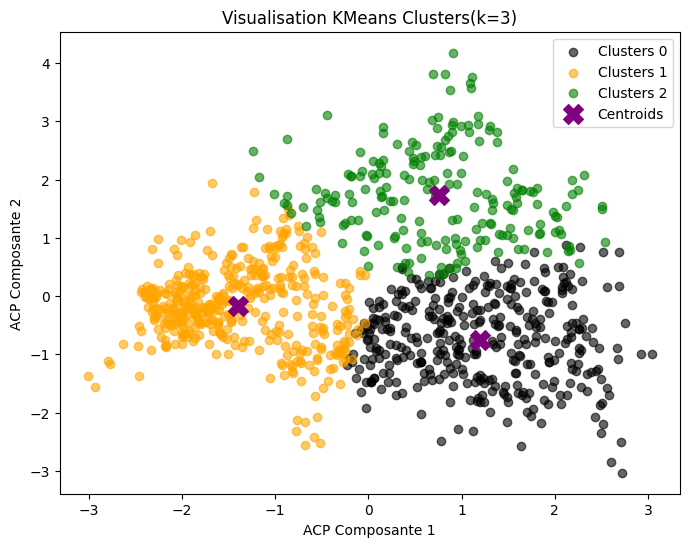

In [20]:
# Centroids
pca = PCA(n_components=10)
data_pca = pca.fit_transform(data_transformed)
centroids = pca.transform(kmean.cluster_centers_)
print("ACP appliquée pour visualiser les centroids")

plt.figure(figsize=(8,6))
colors = ["black","orange","green"]

for i in range(optimal_k):
    plt.scatter(
        data_pca[clusters == i, 0],
        data_pca[clusters == i, 1],
        label =f"Clusters {i}",
        alpha =0.6,
        color =colors[i]
    )

plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=200,c="purple", label ="Centroids")
plt.xlabel("ACP Composante 1")
plt.ylabel("ACP Composante 2")
plt.title(f"Visualisation KMeans Clusters(k={optimal_k})")
plt.legend()
plt.show()

In [22]:
# ====== ANALYSE DES MOYENNES ======
clusters_summary = data_client.groupby("Clusters")[num_col].mean()
clusters_summary

,total_dépense,anciennete_jours,recence_jours,duree_entre_achat
Clusters,,,,
0,2264.629757,773.702703,557.435135,216.267568
1,2634.486432,236.483568,119.478873,117.004695
2,2844.495245,852.318627,166.882353,685.436275


In [23]:
# ====== PROPORTION DE CLUSTER PAR CATEGORIES ======
# Categorie : Pays
cluster_proportion_pays = data_client.groupby("Clusters")["pays"].value_counts(normalize=True)
cluster_proportion_pays

Clusters  pays         
0         Togo             0.256757
          Burkina Faso     0.254054
          Cameroun         0.181081
          Sénégal          0.159459
          Côte d'Ivoire    0.148649
1         Burkina Faso     0.281690
          Togo             0.230047
          Côte d'Ivoire    0.192488
          Sénégal          0.159624
          Cameroun         0.136150
2         Burkina Faso     0.299020
          Togo             0.225490
          Sénégal          0.171569
          Côte d'Ivoire    0.161765
          Cameroun         0.142157
Name: proportion, dtype: float64

In [24]:
# Categorie : Statut des clients
cluster_proportion_statut_client = data_client.groupby("Clusters")["statut_client"].value_counts(normalize=True)
cluster_proportion_statut_client

Clusters  statut_client
0         Inactif          1.000000
1         Actif            0.767606
          Inactif          0.232394
2         Actif            0.558824
          Inactif          0.441176
Name: proportion, dtype: float64